In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import plotly.express as px

In [3]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

In [13]:
data = pd.read_csv('data/Daily net retail sales 5 May 2000  6 April 2003.csv')
data['x'].fillna(data['x'].mean(), inplace=True)
df = data.set_index('x').sort_index()

In [14]:
df

,Unnamed: 0
x,
101105.0,963
101309.0,230
103148.0,597
105900.0,771
108671.0,232
...,...
909531.0,936
914987.0,610
962011.0,596


## Предсказание временного ряда с помощью деревьев

Попробуем обычное дерево решений и случайный лес, а потом сравним результаты

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from numpy import asarray

In [16]:
n_vars = 1 if type(df) is list else df.shape[1]
cols = list()
for i in range(1, 0, -1):
    cols.append(df.shift(i))
for i in range(0, 1):
    cols.append(df.shift(-i))
# put it all together
agg = pd.concat(cols, axis=1)
agg.dropna(inplace=True)
list_for_forecast = agg.values

In [17]:
len(list_for_forecast)

1066

In [18]:
def decision_tree_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = DecisionTreeRegressor(random_state=0)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

In [19]:
def random_forest_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

In [22]:
predictions = list()
size = int(len(list_for_forecast) * 0.66)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = random_forest_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])

error = mean_absolute_error(test[:, -1], predictions)
print("Random Forest error: ", error)

Random Forest error:  296.95961983471074


In [23]:
print("Random Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], predictions))
print("MAE:", mean_absolute_error(test[:, -1], predictions))
print("R2: ", r2_score(test[:, -1], predictions))

Random Forest metrics: 
RMSE: 365.95657004438397
MAPE: 3.5008395575012545
MAE: 296.95961983471074
R2:  -0.42753448103000746


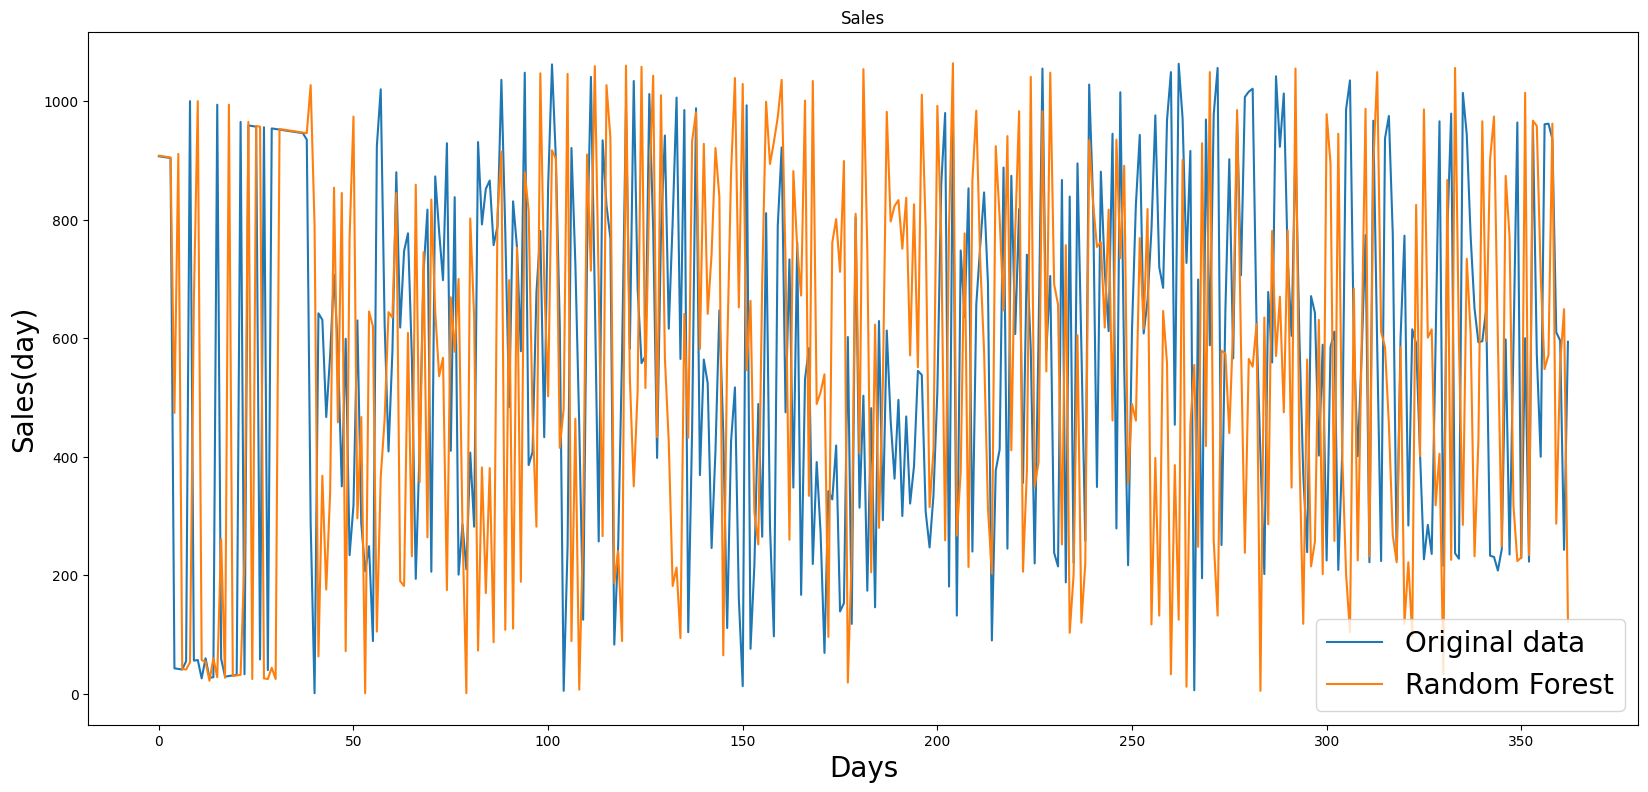

In [27]:
fig = plt.figure(figsize=(20, 9))
plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Random Forest')
plt.legend(fontsize="20")
plt.title('Sales')
plt.ylabel('Sales(day)', fontsize="20")
plt.xlabel('Days', fontsize="20")
plt.show()

In [25]:
predictions = list()
size = int(len(list_for_forecast) * 0.66)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = decision_tree_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])


In [26]:
print("Decision Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], predictions))
print("MAE:", mean_absolute_error(test[:, -1], predictions))
print("R2: ", r2_score(test[:, -1], predictions))

Decision Forest metrics: 
RMSE: 434.4482552633598
MAPE: 4.040423084005656
MAE: 347.1652892561983
R2:  -1.0118871881456721


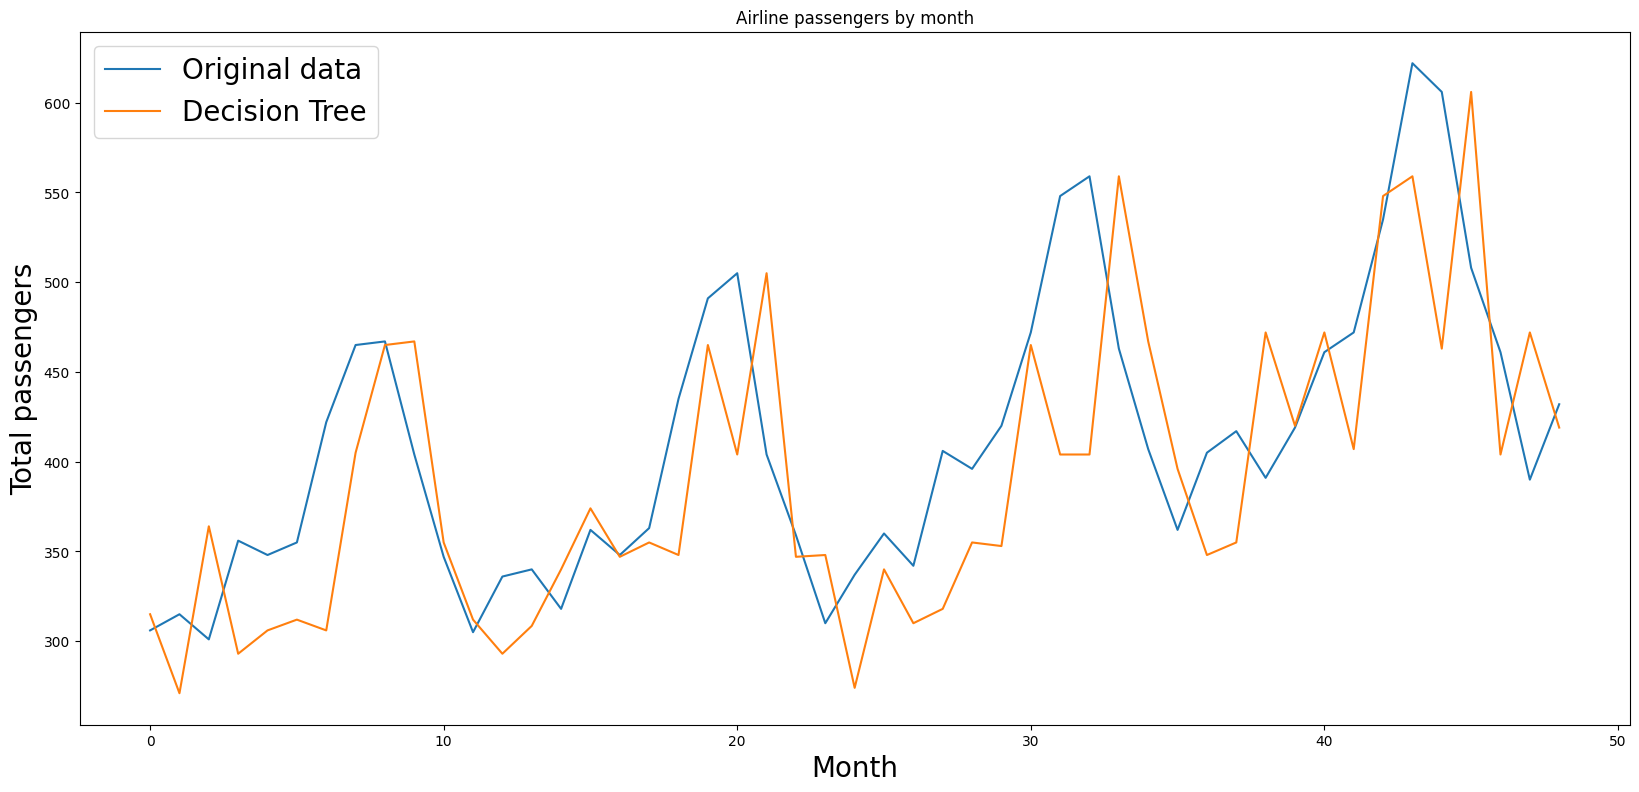

In [24]:
fig = plt.figure(figsize=(20, 9))
plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Decision Tree')
plt.legend(fontsize="20")
plt.title('Sales')
plt.ylabel('Sales (day)', fontsize="20")
plt.xlabel('Days', fontsize="20")
plt.show()

## Детекция аномалий с помощью isolated forest

In [5]:
from sklearn.ensemble import IsolationForest

In [7]:
df = pd.read_csv('data/Daily net retail sales 5 May 2000  6 April 2003.csv')
df['x'].fillna(df['x'].mean(), inplace=True)
df.set_index('x').sort_index()

,Unnamed: 0
x,
101105.0,963
101309.0,230
103148.0,597
105900.0,771
108671.0,232
...,...
909531.0,936
914987.0,610
962011.0,596


In [8]:
model = IsolationForest(contamination=0.004)
model.fit(df[['x']])

IsolationForest(contamination=0.004)

In [9]:
df['outliers'] = pd.Series(model.predict(df[['x']])).apply(lambda x: 'yes' if (x == -1) else 'no' )

In [10]:
df.query('outliers=="yes"')

,Unnamed: 0,x,outliers
242,243,978742.0,yes
593,594,986587.0,yes
595,596,962011.0,yes
609,610,914987.0,yes
935,936,909531.0,yes


In [11]:
fig = px.scatter(df.reset_index(), y='x', color='outliers')
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()